# Tutorial IX - Safety Planning for the Islamic Pilgrimage in Mecca

Applied Optimization with Julia

# Introduction

The Hajj, one of the world’s largest religious gatherings, presents
fascinating and very important optimization challenges. During this
annual pilgrimage to Mecca, millions of Muslims perform sacred rituals,
including the symbolic stoning of the devil. Your task is to create an
efficient scheduling system that ensures both safety and spiritual
fulfillment for all pilgrims.

## The challenge

You’re responsible for scheduling 15 pilgrim groups
$\mathcal{S} \in \{g1,g2,...,g15\}$ across 6 time periods
$\mathcal{T} \in \{t1,t2,...,t6\}$ for the Jamarat ritual.

The groups $\mathcal{S}$ reside in two different camps
$\mathcal{C} \in \{A,B\}$. The first 6 groups are in camp A while the
other groups are in camp B. Each camp has only one path
$\mathcal{P} \in \{A-S-A,B-S-B\}$ and both paths have only one resource
$\mathcal{R}$, the stoning of the devil.

The capacity of the stoning is 10,000 pilgrims per period and there is
no period offset between the stoning and the capacity utilization. Each
group can stone the devil in any period $t$.

To constrain the fluctuation of the resource utilization $\sigma$ was
set to 0.3 while the first period is not constrained. Consider that the
number of pilgrims per group $s$ and the penalty value $f_{s,t}$ are
given.

# 1. Problem Identification

You’ll need to create an optimization model that:

1.  Keeps everyone safe by respecting capacity limits
2.  Maintains steady flow between periods
3.  Maximizes pilgrim satisfaction by considering their time preferences
4.  Ensures efficient use of the available paths

The model can be simplified when compared to the full model from the
lecture in several ways!

Please illustrate possible simplifications in a few sentences in the
cell below and document the key sets, parameters, and decision variables
needed and which elements we can eliminate and why.

> **Tip**
>
> To solve this task, it can be helpful to work with paper and pen to
> sketch the problem, and get a better understanding.

In [1]:
#=
As we have only two camps and each camp has only one path, we can eliminate the camp and paths sets. Furthermore, we can eliminate the path variable as we only have one path per camp. As there is no shift in the resource utilization, we can eliminate the shift parameter. In addition, we only have one ressource which allows us to drop the set R. Now we only have 6 time periods and 15 groups and one resource on which to schedule the stoning. This is a much simpler problem, as we only need to consider the capacity of one resource and the number of pilgrims per group when scheduling the stoning.

Sets:
- T = 1:6
- S = 1:15

Parameters:
- n_s = Number of pilgrims per group
- f_st = Penalty value per group per period
- σ = Allowed fluctuation of the resource utilization (we can drop the set R)
- b = Capacity of the resource per period (we can drop the set R and the set T, as the capacity is the same for all periods)

Decision Variables:
- X_st = 1 if group s is stoned in period t, 0 otherwise
- U_t = Utilization of the resource in period t
=#

# 2. Implementing the Model

Now, implement and solve the problem defined in the previous task. This
time, a draft is not available and you have to implement everything
yourself. Note, that the number of pilgrims per group $s$ and the
penalty value $f_{s,t}$ are provided as CSV files. You can find them in
the `data` folder of this lectures folder in the Github repository.

## Load the Data

Start by loading the data into the notebook for the number of pilgrims
per group and the penalty value per group per period.

In [1]:
# YOUR CODE BELOW
using DelimitedFiles

file_directory = "$(@__DIR__)/data"
number_pilgrims = readdlm("$(file_directory)/pilgrims.csv", ',')
penalty_values = readdlm("$(file_directory)/penalty.csv", ',')

number_pilgrims_dict = Dict(number_pilgrims[i, 1] => number_pilgrims[i, 2] for i in 2:size(number_pilgrims, 1))
penalty_values_dict = Dict((penalty_values[i, 1],penalty_values[1,j]) => penalty_values[i, j] for i in 2:size(penalty_values, 1), j in 2:size(penalty_values, 2))

println(number_pilgrims_dict)
println(penalty_values_dict)

Dict{SubString{String}, Int64}("g12" => 4000, "g11" => 3000, "g2" => 2000, "g8" => 3000, "g6" => 3000, "g1" => 3000, "g9" => 2000, "g15" => 3000, "g5" => 4000, "g13" => 5000, "g14" => 6000, "g7" => 5000, "g10" => 4000, "g4" => 4000, "g3" => 2000)
Dict{Tuple{SubString{String}, SubString{String}}, Float64}(("g2", "t2") => 1.936832418946552, ("g3", "t3") => 0.14880601374343794, ("g1", "t2") => 0.4271597967286924, ("g4", "t1") => 0.1170600255738461, ("g9", "t6") => 1.844501925244554, ("g2", "t5") => 1.063167581053448, ("g9", "t3") => 1.155498074755446, ("g8", "t1") => 1.2707397487757728, ("g2", "t6") => 2.063167581053448, ("g3", "t6") => 2.851193986256562, ("g14", "t6") => 4.373600275820625, ("g15", "t2") => 0.9699744807413038, ("g12", "t5") => 3.7317742869096375, ("g12", "t3") => 1.7317742869096375, ("g13", "t3") => 2.1463653919653307, ("g8", "t6") => 3.729260251224227, ("g9", "t5") => 0.844501925244554, ("g7", "t6") => 0.8428504725799852, ("g5", "t1") => 2.261101565529233, ("g8", "t3") =

## Define all Sets, Parameters and Variables

Please define all sets, parameters and variables you are going to use in
the following cell. Make sure to read the task above carefully, as the
problem can be modelled much simpler than the full model from the
lecture, due to certain properties of the problem.

In [2]:
# YOUR CODE BELOW

# Define the sets
Set_T = sort(collect(penalty_values[1,2:end])) # the first row of penalty_values is the header, so we start from the second column 
Set_S = sort(collect(keys(number_pilgrims_dict))) # collect is used to convert the keys to an array

capacity = 10000 # Define the capacity of the resource
allowed_fluctuation = 0.3 # Define the allowed fluctuation of the resource utilization

using JuMP
using HiGHS 

pilgrim_model = Model(HiGHS.Optimizer)

@variable(pilgrim_model, X[Set_S, Set_T] >= 0, Bin) # Binary decision variable
@variable(pilgrim_model, 0 <= U[Set_T] <= 1) # Utilization of the stoning of the devil

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, Any["t1", "t2", "t3", "t4", "t5", "t6"]
And data, a 6-element Vector{VariableRef}:
 U[t1]
 U[t2]
 U[t3]
 U[t4]
 U[t5]
 U[t6]

## Define the Model

Define the objective function and all constraints of the model in the
following cell.

In [3]:
# YOUR CODE BELOW
# Objective function
@objective(pilgrim_model, Min, sum(penalty_values_dict[(s,t)] * X[s,t] for s in Set_S, t in Set_T))

# Assign each group to a period
@constraint(pilgrim_model, assign_group[s in Set_S], sum(X[s,t] for t in Set_T) == 1)

# Constraint for the number of pilgrims per period
@constraint(pilgrim_model, 
    capacity_constraint[t in Set_T],
    sum(X[s,t] * number_pilgrims_dict[s] for s in Set_S) == U[t] * capacity
)

# Constraint for the fluctuation of the utilization
@constraint(pilgrim_model, fluctuation_1[t in 2:length(Set_T)], U[Set_T[t]] - U[Set_T[t-1]] <= allowed_fluctuation)
@constraint(pilgrim_model, fluctuation_2[t in 2:length(Set_T)], U[Set_T[t-1]] - U[Set_T[t]] <= allowed_fluctuation)

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, 2:6
And data, a 5-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 fluctuation_2[2] : U[t1] - U[t2] ≤ 0.3
 fluctuation_2[3] : U[t2] - U[t3] ≤ 0.3
 fluctuation_2[4] : U[t3] - U[t4] ≤ 0.3
 fluctuation_2[5] : U[t4] - U[t5] ≤ 0.3
 fluctuation_2[6] : U[t5] - U[t6] ≤ 0.3

## Solve the Model

Solve the model and print the results. What is the total dissatisfaction
with the resulting timetable?

In [4]:
# YOUR CODE BELOW
optimize!(pilgrim_model)
# Print total dissatisfaction
println("\nTotal dissatisfaction: $(round(objective_value(pilgrim_model), digits=2))")

# Create a formatted table of assignments
println("\nGroup assignments by period:")
println("-" ^ 50)
println("Group | Assigned Period")
println("-" ^ 50)

for group in Set_S
    assigned_period = findfirst(x -> value(X[group,x]) ≈ 1, Set_T)
    println("$(lpad(group, 5)) | Period $assigned_period")
end

# Print utilization statistics
println("\nUtilization by period:")
println("-" ^ 50)
println("Period | Utilization")
println("-" ^ 50)
for t in Set_T
    util = round(value(U[t]) * 100, digits=1)
    println("$(lpad(t, 6)) | $(util)%")
end

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
31 rows, 96 cols, 206 nonzeros
26 rows, 96 cols, 196 nonzeros

Solving MIP model with:
   26 rows
   96 cols (90 binary, 0 integer, 6 implied int., 0 continuous)
   196 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   4.902331249     9.610605523       48.99%        0      0      0        31     0.0s
 L       0       0         0   0.00%   6.74596059      7.034093282        4.10%       30      7      2        41     0.0s

Solving report
  Status            Optimal
  Primal bound      7.03409328181
  Dual bound        7.03409328181
  Gap      

## Analyze the Results

Plot the utilization of the resource by using the `Plots` package.

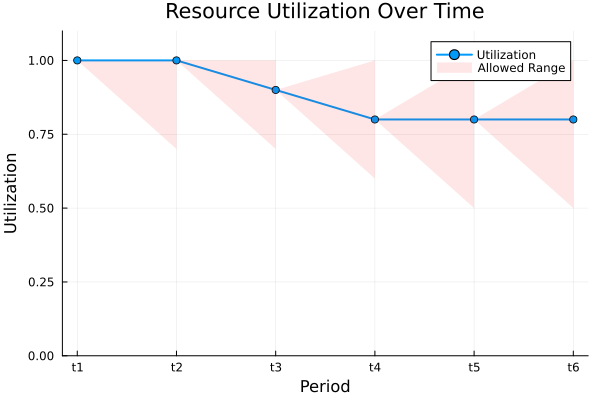

In [5]:
# YOUR CODE BELOW
using Plots

# Create a line plot for utilization
p1 = plot(Set_T, [value(U[t]) for t in Set_T],
    label="Utilization",
    xlabel="Period", 
    ylabel="Utilization",
    title="Resource Utilization Over Time",
    marker=:circle,
    linewidth=2,
    legend=:topright,
    ylims=(0, 1.1),
)

# Add shaded area for allowed fluctuations
for t in 1:length(Set_T)
    if t > 1
        # Get current utilization value
        util = value(U[Set_T[t]])
        prev_util = value(U[Set_T[t-1]])
        
        # Create arrays for upper and lower bounds
        x_coords = [Set_T[t-1], Set_T[t]]
        upper_y = [prev_util, min(1, prev_util + allowed_fluctuation)]
        lower_y = [prev_util, max(0, prev_util - allowed_fluctuation)]
        
        # Plot shaded area between bounds
        plot!(x_coords, upper_y,
            fillrange=lower_y,
            fillalpha=0.1,
            color=:red,
            label=(t==2 ? "Allowed Range" : nothing),
            linealpha=0)
    end
end

# Display the plot
display(p1)

Finally, reflect in a few sentences on the simplifications you made to
the model and how they affected the solution.

In [7]:
#=

We could leave out several sets and parameters, as we only have one resource and one path per camp. This simplified the model significantly. The solutions are not impacted, as we only have one resource and one path per camp and the simplifications do not change the solution space.

=#

------------------------------------------------------------------------

# Solutions

You will likely find solutions to most exercises online. However, I
strongly encourage you to work on these exercises independently without
searching explicitly for the exact answers to the exercises.
Understanding someone else’s solution is very different from developing
your own. Use the lecture notes and try to solve the exercises on your
own. This approach will significantly enhance your learning and
problem-solving skills.

Remember, the goal is not just to complete the exercises, but to
understand the concepts and improve your programming abilities. If you
encounter difficulties, review the lecture materials, experiment with
different approaches, and don’t hesitate to ask for clarification during
class discussions.

Later, you will find the solutions to these exercises online in the
associated GitHub repository, but we will also quickly go over them in
next week’s tutorial. To access the solutions, click on the Github
button on the lower right and search for the folder with today’s lecture
and tutorial. Alternatively, you can ask ChatGPT or Claude to explain
them to you. But please remember, the goal is not just to complete the
exercises, but to understand the concepts and improve your programming
abilities.